# Проблематика
Люди приходят в оффлайн и онлайн-магазины, как правило, за определенным товаром. В интересах покупателя подобрать подходящий для себя вариант и в целом купить себе вещи, которые улучшат жизнь, а в интересах продавца - получить больше прибыли. Выбор зачастую может быть трудным и времязатратным, а ещё в магазине могут быть другие товары, которые были бы по душе покупателю, но он про них не узнает, потому что не искал. Для создания эффективной коммуникации с покупателями компании внедряют современные технологии, основанные на искусственном интеллекте и анализе больших данных. Наиболее популярны из них рекомендательные системы. С их помощью можно быстро и максимально точно предсказать предпочтения потребителя и предложить наиболее подходящий товар или услугу, тем самым увеличить чек, повысить конверсию, уровень удовлетворённости клиента. Рекомендательные системы дают большое преимущество и их отсутствие у крупного ритейлера означает значительную потерю прибыли, а также снижение конкурентоспособности перед компаниями, пользующимися ими. Но не стоит забывать о том, что наличия рекомендательных систем мало, нужно, чтобы они хорошо работали и выдавали актуальные рекомендации. При неправильных рекомендациях пользователи могут испытывать разочарование и снижать свою лояльность к бренду или платформе. Понять, насколько эффективна рекомендательная система, можно по увеличению основных целевых показателей эффективности: увеличение количества проданных товаров, объема продаж, дохода от продаж и даже длительности пользовательской сессии на сайте.
  


# Формализация задачи
Т к датасет состоит только из информации по заказам, а о характеристиках пользователей и товаров ничего не известно, перед нами стоит задача memory-based рекомендаций. Метрики будут считаться по количеству релевантных товаров - т. е. теми, с которыми взаимодействовал пользователь некоторый промежуток времени.

# Оценка пригодности

In [ ]:
!pip install -q statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

Загрузим датасет

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/wb_school_task_1.csv')
df.head()

,user_id,item_id,order_ts
0,550614,264,2023-01-01 00:28:09.000000
1,571051,580,2023-01-01 00:41:47.000000
2,571051,180,2023-01-01 00:41:47.000000
3,47164,5135,2023-01-01 00:53:35.000000
4,219072,2668,2023-01-01 01:02:29.000000


Проверим датасет на наличие пропущенных значений. Если есть, то удаляем

In [ ]:
df.isna().any()

user_id     False
item_id     False
order_ts    False
dtype: bool

Пропущенных значений нет

Проверим на наличие дубликатов

In [ ]:
df[df.duplicated()].head()

,user_id,item_id,order_ts
1305,664350,3540,2023-01-01 05:54:47.000000
1328,516377,1833,2023-01-01 08:26:58.000000
1609,446178,1318,2023-01-01 12:01:39.000000
1904,563915,381,2023-01-01 09:10:04.000000
2280,441487,672,2023-01-01 09:54:05.000000


Дубликаты есть, удалим

In [ ]:
df = df.drop_duplicates()

Проверим, что все строки с временем соответствуют одному формату. Если нет, удалим.

In [ ]:
format_expected = "%Y-%m-%d %H:%M:%S.%f"
matches = pd.to_datetime(df['order_ts'], format=format_expected, errors='coerce').dt.strftime(format_expected) == df['order_ts']

print(matches.all())

True


Строки с временем соответствуют одному формату

Посчитаем, сколько раз каждый пользователь и каждый товар появляется в датасете

In [ ]:
user_counts = df['user_id'].value_counts()
item_counts = df['item_id'].value_counts()
print(user_counts.shape)
print(item_counts.shape)
print(user_counts)
print(item_counts)

(1057265,)
(6562,)
173306    3339
305110    2587
815043    2579
42097     2464
570310    2097
          ... 
162064       1
747703       1
495054       1
600871       1
342597       1
Name: user_id, Length: 1057265, dtype: int64
192     404127
69      326097
390     305835
357     280828
11      273874
         ...  
5898         1
6562         1
6254         1
5909         1
7384         1
Name: item_id, Length: 6562, dtype: int64


В датасете есть значения с достаточным количеством вхождений товаров и пользователей, поэтому можно считать его пригодным для решения поставленной задачи

Сохраним очищенные данные

In [ ]:
df.to_csv('wb_clean_dataset.csv', index=False)

# EDA

Сделаем анализ распределения переменных

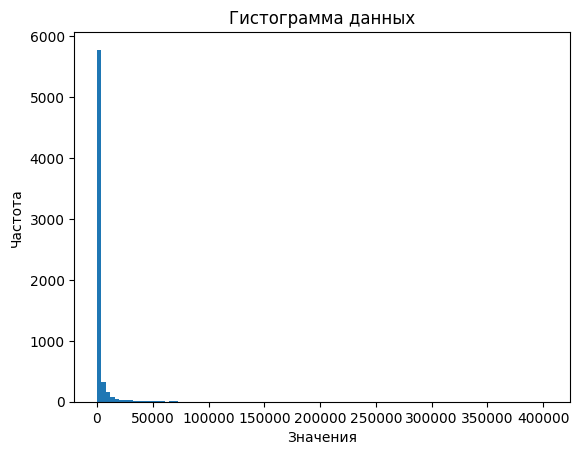

In [ ]:
item_value_counts = df['item_id'].value_counts()
values, bins, _ = plt.hist(item_value_counts.values, bins=100)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Гистограмма данных')
plt.show()

In [ ]:
bins

array([1.0000000e+00, 4.0422600e+03, 8.0835200e+03, 1.2124780e+04,
       1.6166040e+04, 2.0207300e+04, 2.4248560e+04, 2.8289820e+04,
       3.2331080e+04, 3.6372340e+04, 4.0413600e+04, 4.4454860e+04,
       4.8496120e+04, 5.2537380e+04, 5.6578640e+04, 6.0619900e+04,
       6.4661160e+04, 6.8702420e+04, 7.2743680e+04, 7.6784940e+04,
       8.0826200e+04, 8.4867460e+04, 8.8908720e+04, 9.2949980e+04,
       9.6991240e+04, 1.0103250e+05, 1.0507376e+05, 1.0911502e+05,
       1.1315628e+05, 1.1719754e+05, 1.2123880e+05, 1.2528006e+05,
       1.2932132e+05, 1.3336258e+05, 1.3740384e+05, 1.4144510e+05,
       1.4548636e+05, 1.4952762e+05, 1.5356888e+05, 1.5761014e+05,
       1.6165140e+05, 1.6569266e+05, 1.6973392e+05, 1.7377518e+05,
       1.7781644e+05, 1.8185770e+05, 1.8589896e+05, 1.8994022e+05,
       1.9398148e+05, 1.9802274e+05, 2.0206400e+05, 2.0610526e+05,
       2.1014652e+05, 2.1418778e+05, 2.1822904e+05, 2.2227030e+05,
       2.2631156e+05, 2.3035282e+05, 2.3439408e+05, 2.3843534e

В датасете сильный перевес в сторону товаров, с которыми меньше заказов, что логично. Почистим датасет от редких товаров, считая редкими те, которые меньше медианы более чем на 1.1 стандартного отклонения среди товаров, меньших медианы.

In [ ]:
median = item_value_counts.median()
less_part = item_value_counts[item_value_counts < median]
std_deviation = (sum((value - median) ** 2 for value in less_part) / less_part.shape[0]) ** 0.5
filtered_values = item_value_counts[item_value_counts > median - 1.1 * std_deviation]
filtered_df = df[df['item_id'].isin(filtered_values.index)]

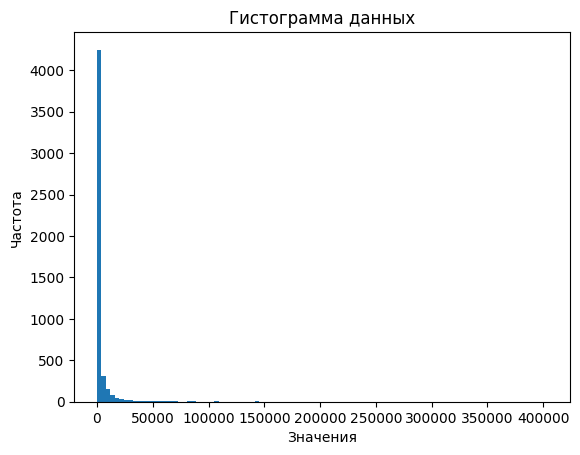

In [ ]:
item_value_counts = filtered_df['item_id'].value_counts()
values, bins, _ = plt.hist(item_value_counts.values, bins=100)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Гистограмма данных')
plt.show()

Уберём в визуализации значения < 50000 для наглядности

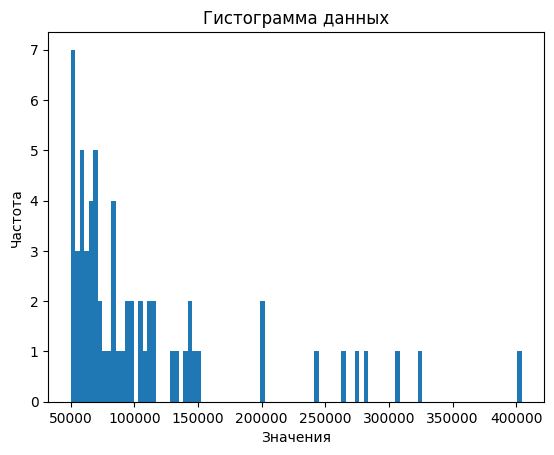

In [ ]:
item_value_counts = filtered_df['item_id'].value_counts()
values, bins, _ = plt.hist(item_value_counts.values[item_value_counts.values >= 50000], bins=100)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Гистограмма данных')
plt.show()

Популярность > 100000 - единичные случаи, что логично

Посмотрим распределение частот для пользователей

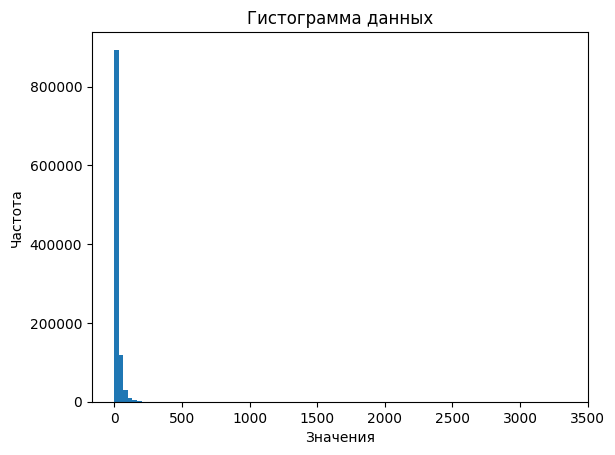

In [ ]:
user_value_counts = filtered_df['user_id'].value_counts()
values, bins, _ = plt.hist(user_value_counts.values, bins=100)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Гистограмма данных')
plt.show()

In [ ]:
bins

array([1.00000e+00, 3.43400e+01, 6.76800e+01, 1.01020e+02, 1.34360e+02,
       1.67700e+02, 2.01040e+02, 2.34380e+02, 2.67720e+02, 3.01060e+02,
       3.34400e+02, 3.67740e+02, 4.01080e+02, 4.34420e+02, 4.67760e+02,
       5.01100e+02, 5.34440e+02, 5.67780e+02, 6.01120e+02, 6.34460e+02,
       6.67800e+02, 7.01140e+02, 7.34480e+02, 7.67820e+02, 8.01160e+02,
       8.34500e+02, 8.67840e+02, 9.01180e+02, 9.34520e+02, 9.67860e+02,
       1.00120e+03, 1.03454e+03, 1.06788e+03, 1.10122e+03, 1.13456e+03,
       1.16790e+03, 1.20124e+03, 1.23458e+03, 1.26792e+03, 1.30126e+03,
       1.33460e+03, 1.36794e+03, 1.40128e+03, 1.43462e+03, 1.46796e+03,
       1.50130e+03, 1.53464e+03, 1.56798e+03, 1.60132e+03, 1.63466e+03,
       1.66800e+03, 1.70134e+03, 1.73468e+03, 1.76802e+03, 1.80136e+03,
       1.83470e+03, 1.86804e+03, 1.90138e+03, 1.93472e+03, 1.96806e+03,
       2.00140e+03, 2.03474e+03, 2.06808e+03, 2.10142e+03, 2.13476e+03,
       2.16810e+03, 2.20144e+03, 2.23478e+03, 2.26812e+03, 2.301

В датасете сильный перевес в сторону покупателей, у которых меньше заказов, что логично. Нужно будет учитывать возможность "холодного старта" в решении. Чистить датасет от редких пользователей не будем, т к это повлияет на распределение товаров - придётся заново чистить датасет от редких товаров, а потом возможно снова от редких пользователей и т. д.

Уберём в визуализации значения < 500 для наглядности

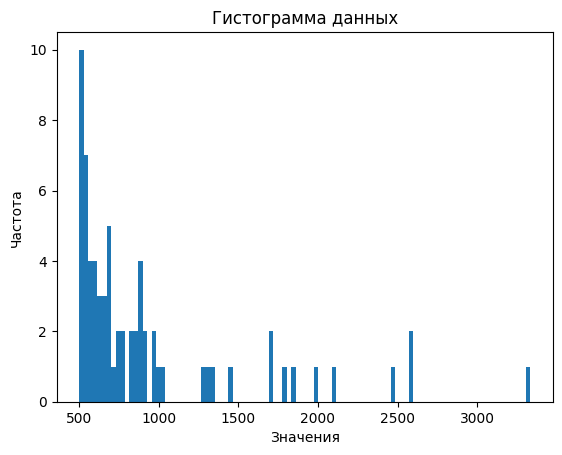

In [ ]:
user_value_counts = filtered_df['user_id'].value_counts()
values, bins, _ = plt.hist(user_value_counts.values[user_value_counts.values >= 500], bins=100)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Гистограмма данных')
plt.show()

Популярность > 600- единичные случаи, что логично

In [ ]:
df = filtered_df

In [ ]:
df.to_csv('wb_filtered_data.csv', index=False)

Посмотрим индекс корреляции между покупателями и товарами

In [ ]:
correlation = df['user_id'].corr(df['item_id'])
correlation

0.0008640231517734558

Корреляции нет, что допустимо для задачи memory-based рекомендаций

In [ ]:
df = pd.read_csv('wb_filtered_data.csv')

In [ ]:
df.head()

,user_id,item_id,order_ts
0,550614,264,2023-01-01 00:28:09.000000
1,571051,580,2023-01-01 00:41:47.000000
2,571051,180,2023-01-01 00:41:47.000000
3,47164,5135,2023-01-01 00:53:35.000000
4,219072,2668,2023-01-01 01:02:29.000000


Посмотрим на временные тенденции

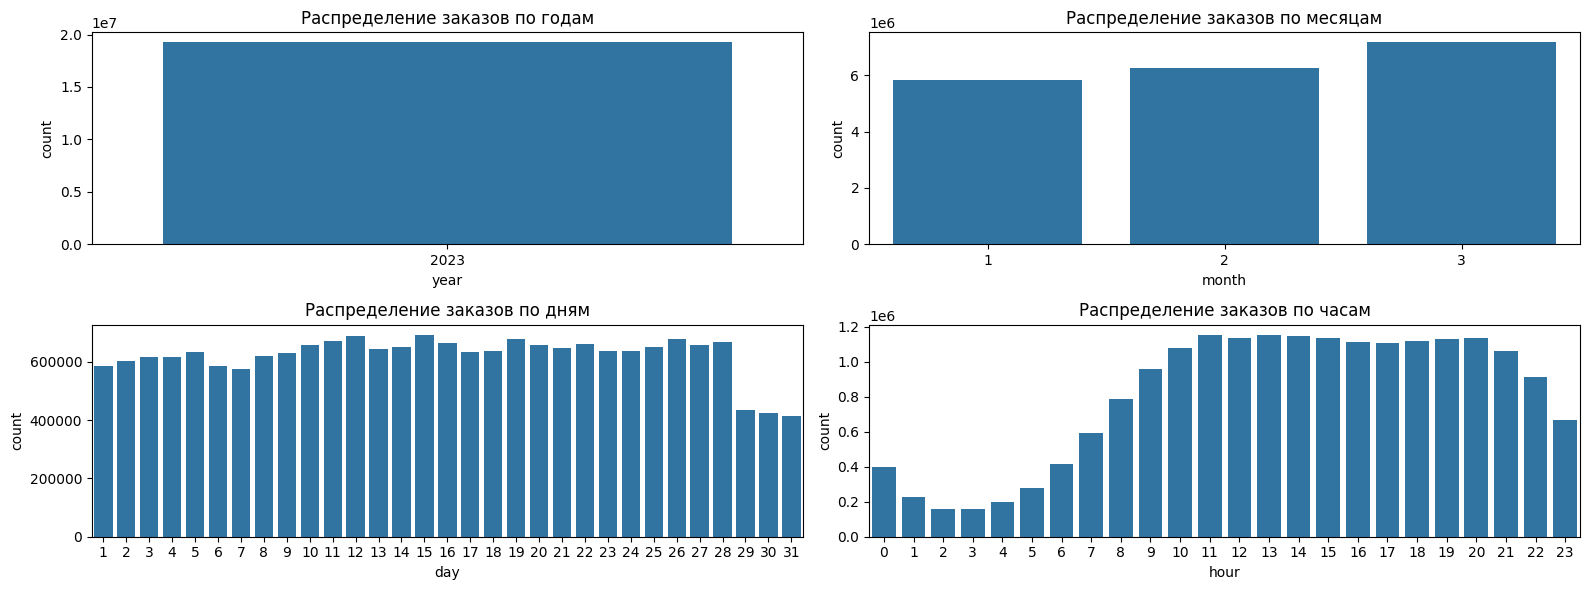

In [ ]:
# Преобразуем столбец с временем заказа в формат datetime
df['order_ts'] = pd.to_datetime(df['order_ts'])

# Создаём новые столбцы для группировки по годам, месяцам, дням и часам
df['year'] = df['order_ts'].dt.year
df['month'] = df['order_ts'].dt.month
df['day'] = df['order_ts'].dt.day
df['hour'] = df['order_ts'].dt.hour

# Выводим графики распределения заказов по годам, месяцам, дням и часам
plt.figure(figsize=(16, 6))
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='year')
plt.title('Распределение заказов по годам')
plt.subplot(2, 2, 2)
sns.countplot(data=df, x='month')
plt.title('Распределение заказов по месяцам')
plt.subplot(2, 2, 3)
sns.countplot(data=df, x='day')
plt.title('Распределение заказов по дням')
plt.subplot(2, 2, 4)
sns.countplot(data=df, x='hour')
plt.title('Распределение заказов по часам')
plt.tight_layout()
plt.show()

В датасете только 1 год и 3 месяца, так что распределение по дням лучше посмотреть по каждому месяцу отдельно. По часам покупки распределены по большей части равномерно, в основном они совершаются с 9 до 21. Контекст времени может быть добавлен в алгоритмы рекомендаций для более точного предсказания потребностей пользователей на основе их покупок или действий в конкретное время

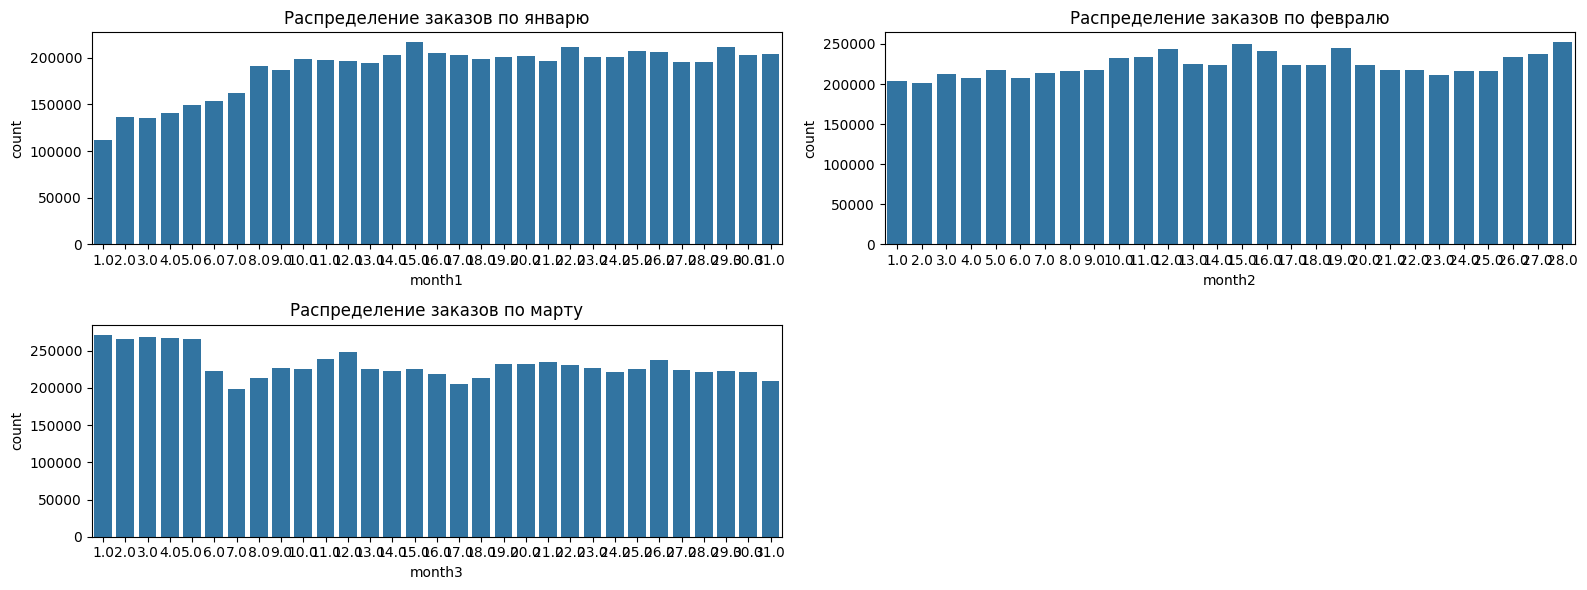

In [ ]:
df['month1'] = df['order_ts'][df['order_ts'].dt.month == 1].dt.day
df['month2'] = df['order_ts'][df['order_ts'].dt.month == 2].dt.day
df['month3'] = df['order_ts'][df['order_ts'].dt.month == 3].dt.day

plt.figure(figsize=(16, 6))
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='month1')
plt.title('Распределение заказов по январю')
plt.subplot(2, 2, 2)
sns.countplot(data=df, x='month2')
plt.title('Распределение заказов по февралю')
plt.subplot(2, 2, 3)
sns.countplot(data=df, x='month3')
plt.title('Распределение заказов по марту')
plt.tight_layout()
plt.show()

По дням покупки распределены равномерно в каждом месяце, закономерности нет

Посмотрим сезонные тренды для 6 наиболее популярных товаров

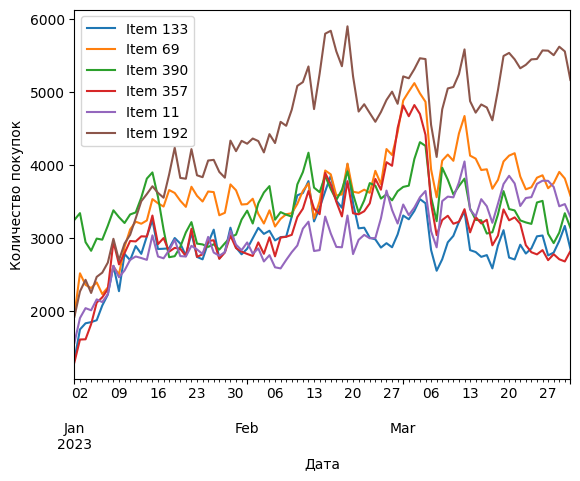

In [ ]:
# Группируем данные по 'item_id' и подсчитываем их количество
popular_items = df['item_id'].value_counts().nlargest(6)

# Фильтрация датафрейма для оставления только строк с популярными значениями item_id
df_filtered = df[df['item_id'].isin(popular_items.index)]

# Создаем подграфики для каждого товара
fig, ax = plt.subplots()
for item in df_filtered['item_id'].unique():
    item_data = df_filtered[df_filtered['item_id'] == item]
    item_data = item_data.set_index('order_ts')
    item_data.resample('D').size().plot(ax=ax, label=f'Item {item}')

ax.set_xlabel('Дата')
ax.set_ylabel('Количество покупок')
ax.legend()
plt.show()

У всех товаров популярность возросла по сравнению с началом января. Это может отражать изменения трендов или потребительского поведения, что стоит учитывать при построении модели. Исследуем временные ряды

In [ ]:
def decompose_time_series(data):
    decomposition = seasonal_decompose(data, model='additive')
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    return trend, seasonal, residual

def exponential_smoothing(data, smoothing_level):
    model = SimpleExpSmoothing(data)
    model_fit = model.fit(smoothing_level=smoothing_level)
    smoothed_data = model_fit.fittedvalues
    return smoothed_data

Построим декомпозицию на тренды и сезонность

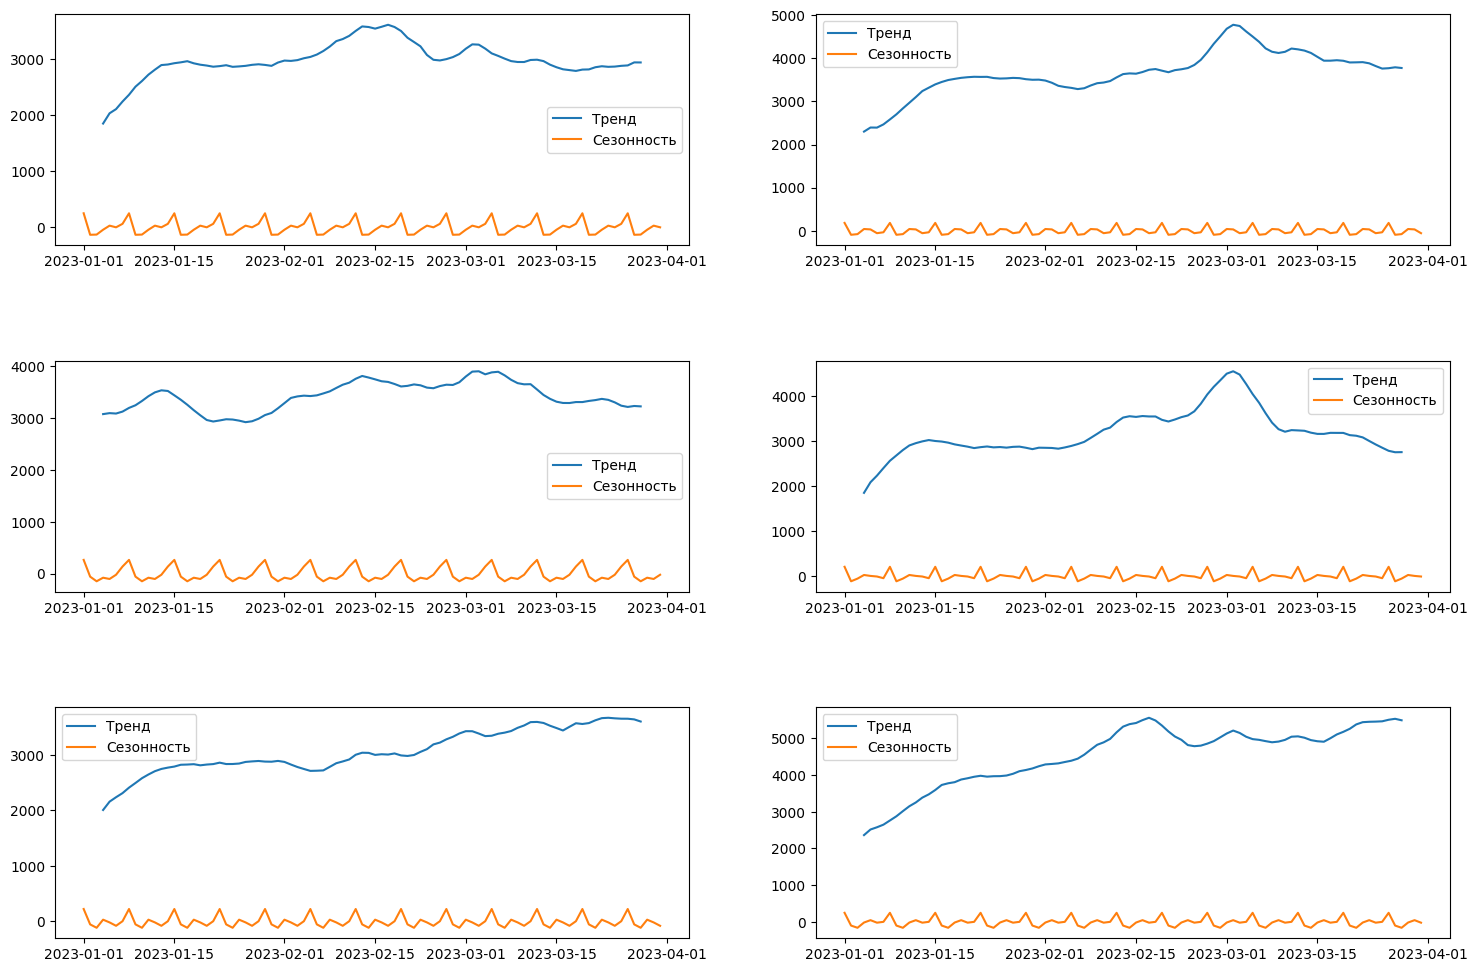

In [ ]:
popular_items = df['item_id'].value_counts().nlargest(6)
df_filtered = df[df['item_id'].isin(popular_items.index)]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5)
items = df_filtered['item_id'].unique()
for i, ax in enumerate(axes.flatten()):
  item_data = df_filtered[df_filtered['item_id'] == items[i]]
  item_data = item_data.set_index('order_ts')
  item_data = item_data.resample('D').size()
  trend, seasonal, residual = decompose_time_series(item_data)
  ax.plot(trend, label='Тренд')
  ax.plot(seasonal, label='Сезонность')
  ax.legend()

По графикам видно, что есть повторяющиеся сезонные паттерны. По трендам сложно делать выводы, нет чёткой восходящей или нисходящей траекторий, только небольшие локальные минимумы/максимумы, которые ни о чём не говорят

Попробуем применить экспоненциальное сглаживание (Exponential Smoothing), чтобы увидеть общий тренд в данных

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress

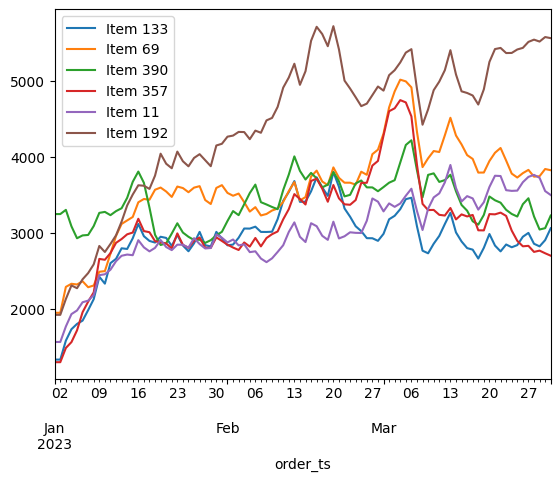

In [ ]:
smoothing_level = 0.6
popular_items = df['item_id'].value_counts().nlargest(6)
df_filtered = df[df['item_id'].isin(popular_items.index)]
fig, ax = plt.subplots()
for item in df_filtered['item_id'].unique():
    item_data = df_filtered[df_filtered['item_id'] == item]
    item_data = item_data.set_index('order_ts')
    smoothed_data = exponential_smoothing(item_data.resample('D').size(), smoothing_level)
    smoothed_data.plot(ax=ax, label=f'Item {item}')

ax.legend()
plt.show()

Результаты не сильно отличаются от исходных данных, сложно что-то выявить

Попробуем обучить модель ARIMA и посмотреть точность предсказаний

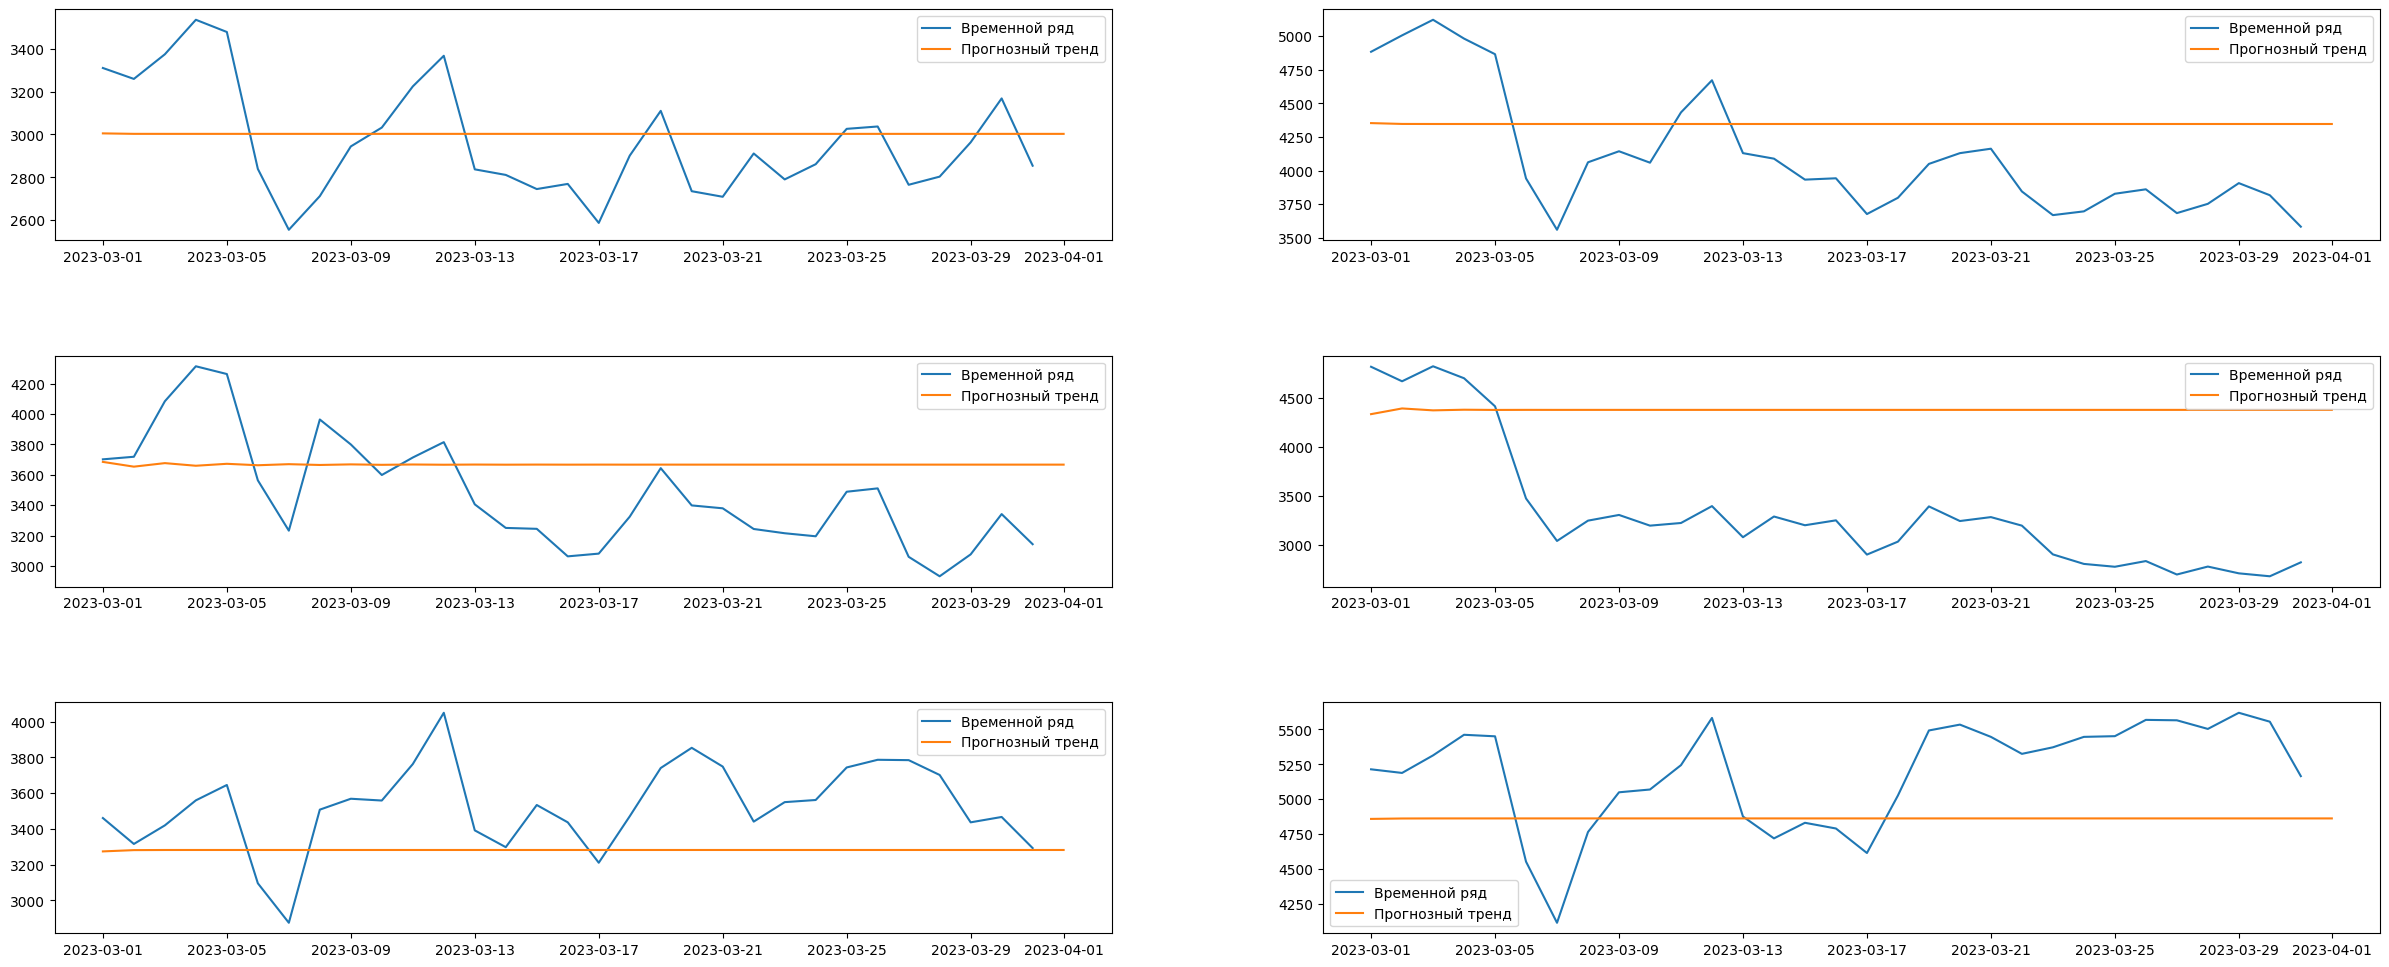

In [ ]:
smoothing_level = 0.6
popular_items = df['item_id'].value_counts().nlargest(6)
df_filtered = df[df['item_id'].isin(popular_items.index)]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 12))
plt.subplots_adjust(hspace=0.5)
items = df_filtered['item_id'].unique()
for i, ax in enumerate(axes.flatten()):
  item_data = df_filtered[(df_filtered['item_id'] == items[i]) & (df_filtered['order_ts'] < '2023-03-01')]
  item_data = item_data.set_index('order_ts')
  item_data = item_data.resample('D').size()
  model = ARIMA(item_data, order=(1, 1, 1))  # Параметры (p, d, q) указывают порядок авторегрессионной, разностной и скользящей составляющих
  results = model.fit()
  validation_data = df_filtered[(df_filtered['item_id'] == items[i]) & (df_filtered['order_ts'] >= '2023-03-01')]
  validation_data = validation_data.set_index('order_ts')
  validation_data = validation_data.resample('D').size()
  forecast_values = results.predict(start='2023-03-01', end='2023-04-01')
  ax.plot(validation_data, label='Временной ряд')
  ax.plot(forecast_values, label='Прогнозный тренд')
  ax.legend()

Модель ничего не предсказывает. Либо недостаточно данных, либо нет закономерностей.  
Итого мы выявили сезонность, про тренды ничего сказать нельзя. Сезонность можно будет учитывать при формировании итоговых рекомендаций: в какой момент времени товар купят с большей вероятностью

Посмотрим статистику количества покупок товара разными пользователями по товарам, которые купили более 5 раз (произвольное фиксированное значение)

In [ ]:
# Группировка данных по 'user_id' и 'item_id' и подсчет уникальных значений 'order_ts'
grouped_df = df.groupby(['user_id', 'item_id'])['order_ts'].nunique().reset_index()
grouped_df = grouped_df[grouped_df['order_ts'] > 5]

Чтобы таблица была не слишком объёмной, но наглядной, возьмём 10 самых популярных пользователей и 10 самых популярных товаров (произвольное фиксированное значение)

In [ ]:
n = 10
user_counts = grouped_df['user_id'].value_counts()
popular_users = user_counts.nlargest(n).index

# Фильтрация датафрейма для оставления только строк с популярными значениями user_id
filtered_df = grouped_df[grouped_df['user_id'].isin(popular_users)]
item_counts = filtered_df['item_id'].value_counts()
popular_items = item_counts.nlargest(n).index
# Фильтрация датафрейма для оставления только строк с популярными значениями item_id
filtered_df = filtered_df[filtered_df['item_id'].isin(popular_items)]

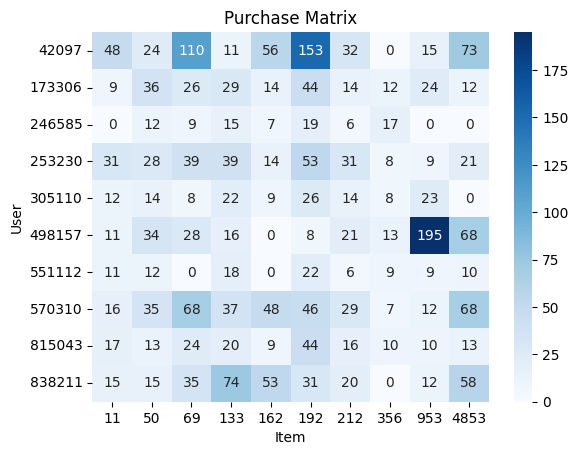

In [ ]:
# Создание сводной таблицы из полученных данных
pivot_table = filtered_df.pivot_table(index='user_id', columns='item_id', values='order_ts', fill_value=0)

# Визуализация матрицы
sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt='d')

plt.xlabel('Item')
plt.ylabel('User')
plt.title('Purchase Matrix')

plt.show()

В матрице встречаются пользователи, покупающие одни и те же товары, что можно будет использовать для определения схожести предпочтений покупателей, т е user-based подход. Допустим, если пользователь купил некоторый набор товаров, а до него было много других пользователей, которые покупали те же самые товары и ещё какие-нибудь, можно посоветовать пользователю эти дополнительные товары.

Посмотрим, есть ли товары, которые один и тот же пользователь купил в одно и то же время

In [ ]:
# Группировка данных по 'user_id' и 'order_ts' и подсчет уникальных значений 'item_id'
grouped_df = df.groupby(['user_id', 'order_ts'])['item_id'].nunique().reset_index()
grouped_df[grouped_df['item_id'] > 1].shape

(1612427, 3)

Да, есть, и много. Построим сводную таблицу по этим товарам. Чтобы таблица не была слишком объёмной, оставим значения > 10, возьмём 10 самых популярных пользователей и 10 самых популярных товаров (произвольное фиксированное значение)

In [ ]:
grouped_df = grouped_df[grouped_df['item_id'] > n]
user_counts = grouped_df['user_id'].value_counts()
popular_users = user_counts.nlargest(n).index
filtered_df = df[df['user_id'].isin(popular_users)]
item_counts = filtered_df['item_id'].value_counts()
popular_items = item_counts.nlargest(n).index
filtered_df = filtered_df[filtered_df['item_id'].isin(popular_items)]

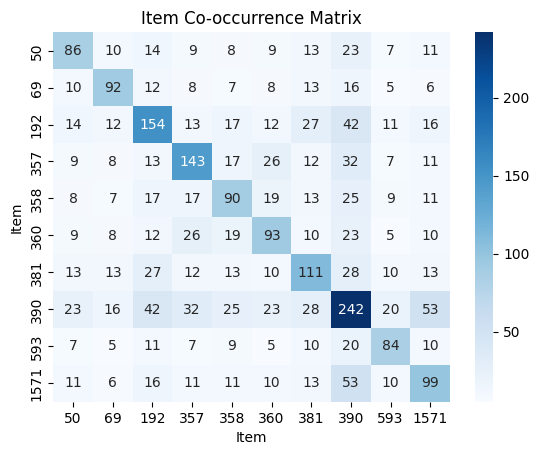

In [ ]:
# Создание глубокой копии filtered_df
df2 = filtered_df.copy(deep=True)

# Соединение таблиц по условию (INNER JOIN)
merged = pd.merge(filtered_df, df2, on=['user_id', 'order_ts'])

# Создание сводной таблицы
matrix = merged.pivot_table(index='item_id_x', columns='item_id_y', aggfunc='size', fill_value=0)
sns.heatmap(matrix, cmap='Blues', annot=True, fmt='d')

plt.xlabel('Item')
plt.ylabel('Item')
plt.title('Item Co-occurrence Matrix')

plt.show()

Популярные товары неплохо коррелируют между собой по одновременным покупкам одним и тем же пользователем, что можно будет использовать для определения их схожести: если товар X часто покупают вместе с товаром Y, то пользователю, покупающему X, можно посоветовать Y, т е использовать item-based подход.